<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning repository
Importing files regarding dataset, model, mains and utils

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 135 (delta 71), reused 70 (delta 35), pack-reused 0
Receiving objects: 100% (135/135), 3.72 MiB | 6.39 MiB/s, done.
Resolving deltas: 100% (71/71), done.


Installing dependencies

In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
!pip install -q opendatasets # quient install, for some reason this does not get installed with requirements

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## Libraries and Initializations

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import (weights_init,
                             train_model,
                             get_correct_predictions,
                             test_model)

import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


### Initializing configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [5]:
expw_obj = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
in EXPW()...
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:13<00:00, 112MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
Directory dataset/expwds already exists.
Directory dataset/expwds already exists.
 length of EXPW dataset : 54476 , 54476


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


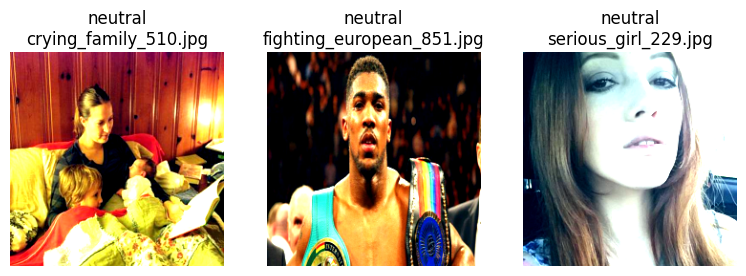

In [6]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


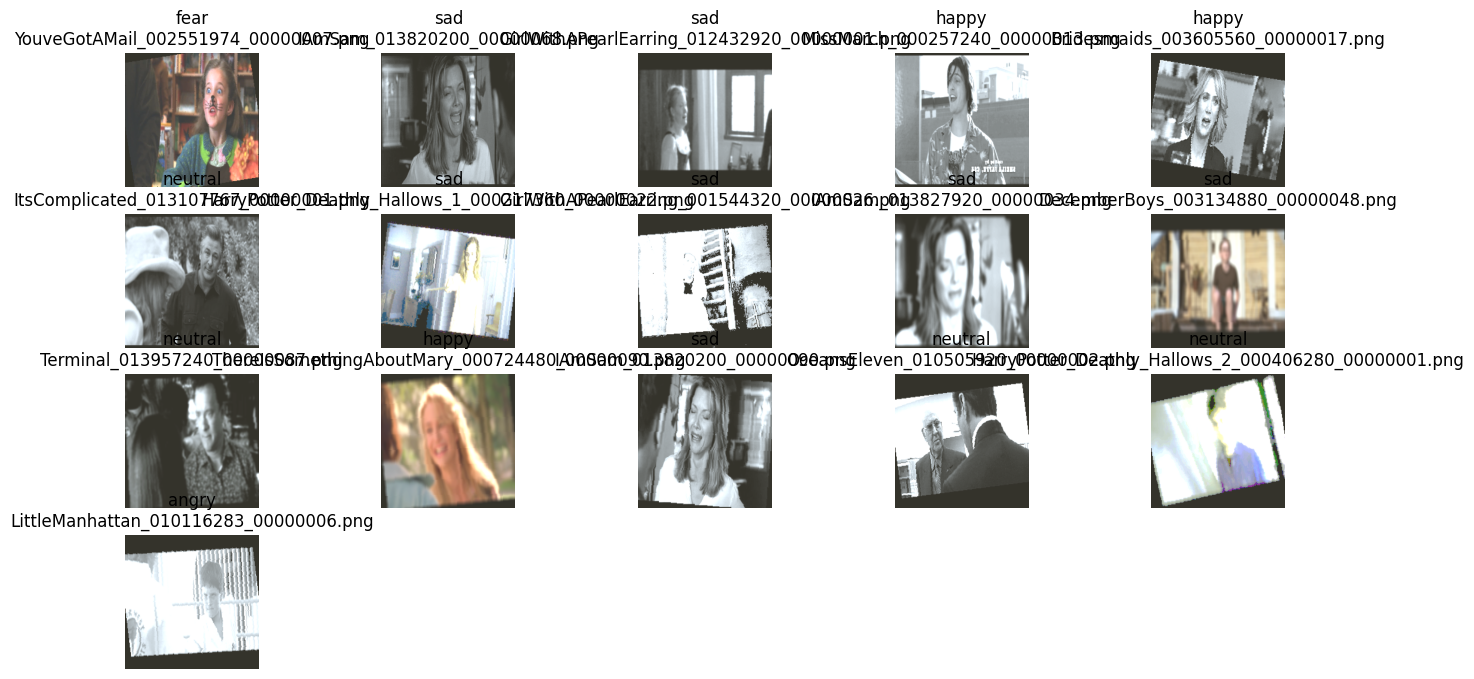

In [7]:
show_batch(sfew_train_loader,sfew.labels,16)


## Initializing Model

In [8]:
model = DANN(num_classes=7, dropout=0.1)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

### Checking Training - one forward pass
Useful to understand input and output. Specially, sizes of input and output (including batch sizes)

In [9]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

# data_loader = {'source_train_loader':sfew_train_loader,
#                'source_val_loader':sfew_val_loader,
#                'target_train_loader':expw_train_loader,
#                'target_val_loader':expw_val_loader}

NameError: name 'expw_train_loader' is not defined

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

cuda


In [13]:
for usage, dict_data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(usage)
    # for name, train_loader, val_loader in data_loader.items()
    for k, v in dict_data_loader.items():
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ",labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ",domains: ",x_domains.shape, ",features: ", x_features.shape)




--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) ,labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) ,domains:  torch.Size([16, 2]) ,features:  torch.Size([16, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) ,labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) ,domains:  torch.Size([16, 2]) ,features:  torch.Size([16, 1000])
--------------------------------------------------------------------------------
target
--------name of dataset : expw--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) ,labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) ,domains:  torch.Size([16, 2]) ,features:  torch.Size([16, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) ,labels:  to

In [14]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

In [15]:
# #@title Typical Training Function with Learning rate

# def train_model(model,device, data_loader, optimizer, epoch,
#                 class_loss_function = nn.CrossEntropyLoss() ):
#     print(f'epoch = {epoch+1}...in training function')

#     model.train() # setting model to training
#     model.to(device)

#     pbar = tqdm(data_loader) # putting the dataloader in progress bar

#     processed = 0 # to understand accuracy, used in denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):
#         images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels

#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

#         class_loss = class_loss_function(class_output,labels) # Calculate Loss
#         epoch_loss += class_loss.item()

#         class_loss.backward() #backpropogation, creating gradients

#         optimizer.step() # updating the params

#         processed += len(images)
#         curr_lr = optimizer.param_groups[0]['lr']

#         pbar.set_description(desc= f'Loss={class_loss.item()} Batch_id={batch_idx+1} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

#     return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [16]:
# def get_correct_predictions(prediction, labels):
#     """
#     Function to return total number of correct predictions
#     :param prediction: Model predictions on a given sample of data
#     :param labels: Correct labels of a given sample of data
#     :return: Number of correct predictions
#     """
#     # print(prediction)
#     # print(prediction.argmax(dim=1))
#     # print(f'labels = {labels}, labels.argmax ={labels.argmax(dim=1)}')
#     # # print(prediction.argmax(dim=1).eq(labels))
#     # # print(prediction.argmax(dim=1).eq(labels).sum())
#     # # print(prediction.argmax(dim=1).eq(labels).sum().item())
#     # # return prediction.argmax(dim=1).eq(labels).sum().item()
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum())
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item())
#     return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [17]:


# #@title Typical Test Function
# def test_model(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_predictions(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#         100. * correct / len(data_loader.dataset)))


#     return correct, test_loss



## Non DANN: Training, Validating, Saving

### Scheduler - ReduceLRonPlateau

In [18]:

# from torch.optim.lr_scheduler import ReduceLROnPlateau


# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_metric = float('inf')  # Adjust based on your metric (e.g., validation loss)
#         self.early_stop = False

#     def __call__(self, metric):
#         if metric < self.best_metric:
#             self.best_metric = metric
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         return self.early_stop

# class CustomModel(nn.Module):
#     # Define your model architecture here

# # Assuming you have a DataLoader for your dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# # Instantiate your model
# model = CustomModel()

# # Set up your loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

# # Set up EarlyStopping callback
# early_stopping = EarlyStopping(patience=5, verbose=True)



#     # Adjust learning rate based on validation loss
#     scheduler.step(val_loss)

#     # Check for early stopping
#     if early_stopping(val_loss):
#         print("Early stopping")
#         break

# # Save or use the trained model



In [11]:
def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1):
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

In [12]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)
# lr = lr * 2 # overriding

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
EPOCHS = 50 # overriding
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = runconfig.early_stop_patience
early_stop_difference = runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              min_lr=1e-6,
                              verbose= True)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based

EPOCHS 50


In [13]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = sfew_train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)

    if early_stopping_difference(val_losses,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

correct, test_loss_source = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader, # source val loader
                                    class_loss_function = criterion_class)

correct, test_loss_target = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = expw_val_loader, # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses_list_sfew_expw = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}




------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  50
epoch = 1...in training function


Loss=2.038755178451538 Accuracy=172/958(17.95%) Epoch Avg loss=0.12231717 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Test / Val: Average loss: 0.1228, Accuracy: 91/436 (20.87%)

EPOCH: 2  of  50
epoch = 2...in training function


Loss=1.9577528238296509 Accuracy=206/958(21.50%) Epoch Avg loss=0.11772016 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Test / Val: Average loss: 0.1221, Accuracy: 98/436 (22.48%)

EPOCH: 3  of  50
epoch = 3...in training function


Loss=1.9236218929290771 Accuracy=238/958(24.84%) Epoch Avg loss=0.11607077 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Test / Val: Average loss: 0.1229, Accuracy: 101/436 (23.17%)

EPOCH: 4  of  50
epoch = 4...in training function


Loss=1.91428542137146 Accuracy=247/958(25.78%) Epoch Avg loss=0.11435706 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


Test / Val: Average loss: 0.1227, Accuracy: 89/436 (20.41%)

EPOCH: 5  of  50
epoch = 5...in training function


Loss=1.5957800149917603 Accuracy=274/958(28.60%) Epoch Avg loss=0.11382102 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.50it/s]


Test / Val: Average loss: 0.1267, Accuracy: 79/436 (18.12%)

EPOCH: 6  of  50
epoch = 6...in training function


Loss=1.7674918174743652 Accuracy=282/958(29.44%) Epoch Avg loss=0.11217477 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


Test / Val: Average loss: 0.1259, Accuracy: 79/436 (18.12%)

EPOCH: 7  of  50
epoch = 7...in training function


Loss=1.8270316123962402 Accuracy=280/958(29.23%) Epoch Avg loss=0.11117600 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


Test / Val: Average loss: 0.1272, Accuracy: 89/436 (20.41%)

EPOCH: 8  of  50
epoch = 8...in training function


Loss=1.7652207612991333 Accuracy=323/958(33.72%) Epoch Avg loss=0.10841221 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


Test / Val: Average loss: 0.1292, Accuracy: 74/436 (16.97%)

EPOCH: 9  of  50
epoch = 9...in training function


Loss=1.5516304969787598 Accuracy=330/958(34.45%) Epoch Avg loss=0.10595762 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.46it/s]


Test / Val: Average loss: 0.1279, Accuracy: 83/436 (19.04%)

EPOCH: 10  of  50
epoch = 10...in training function


Loss=1.881748914718628 Accuracy=367/958(38.31%) Epoch Avg loss=0.10304694 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Test / Val: Average loss: 0.1274, Accuracy: 91/436 (20.87%)

EPOCH: 11  of  50
epoch = 11...in training function


Loss=1.3575584888458252 Accuracy=383/958(39.98%) Epoch Avg loss=0.10008871 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Test / Val: Average loss: 0.1303, Accuracy: 98/436 (22.48%)

EPOCH: 12  of  50
epoch = 12...in training function


Loss=1.6208250522613525 Accuracy=393/958(41.02%) Epoch Avg loss=0.10005055 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Test / Val: Average loss: 0.1333, Accuracy: 89/436 (20.41%)

EPOCH: 13  of  50
epoch = 13...in training function


Loss=1.4581972360610962 Accuracy=428/958(44.68%) Epoch Avg loss=0.09467136 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.52it/s]


Test / Val: Average loss: 0.1308, Accuracy: 95/436 (21.79%)

EPOCH: 14  of  50
epoch = 14...in training function


Loss=1.6417227983474731 Accuracy=432/958(45.09%) Epoch Avg loss=0.09150879 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Test / Val: Average loss: 0.1314, Accuracy: 96/436 (22.02%)

EPOCH: 15  of  50
epoch = 15...in training function


Loss=1.378732442855835 Accuracy=456/958(47.60%) Epoch Avg loss=0.08919339 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.37it/s]


Test / Val: Average loss: 0.1329, Accuracy: 105/436 (24.08%)

EPOCH: 16  of  50
epoch = 16...in training function


Loss=1.4929654598236084 Accuracy=502/958(52.40%) Epoch Avg loss=0.08417851 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.52it/s]


Test / Val: Average loss: 0.1330, Accuracy: 117/436 (26.83%)

EPOCH: 17  of  50
epoch = 17...in training function


Loss=1.0706002712249756 Accuracy=510/958(53.24%) Epoch Avg loss=0.08143162 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


Test / Val: Average loss: 0.1272, Accuracy: 111/436 (25.46%)

EPOCH: 18  of  50
epoch = 18...in training function


Loss=1.6870992183685303 Accuracy=515/958(53.76%) Epoch Avg loss=0.07717396 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Test / Val: Average loss: 0.1337, Accuracy: 110/436 (25.23%)

EPOCH: 19  of  50
epoch = 19...in training function


Loss=1.1513032913208008 Accuracy=550/958(57.41%) Epoch Avg loss=0.07473562 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Test / Val: Average loss: 0.1327, Accuracy: 111/436 (25.46%)

EPOCH: 20  of  50
epoch = 20...in training function


Loss=1.0715200901031494 Accuracy=577/958(60.23%) Epoch Avg loss=0.07212604 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Test / Val: Average loss: 0.1321, Accuracy: 95/436 (21.79%)

EPOCH: 21  of  50
epoch = 21...in training function


Loss=1.0506160259246826 Accuracy=583/958(60.86%) Epoch Avg loss=0.06808754 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


Test / Val: Average loss: 0.1340, Accuracy: 91/436 (20.87%)

EPOCH: 22  of  50
epoch = 22...in training function


Loss=0.6730263829231262 Accuracy=632/958(65.97%) Epoch Avg loss=0.06054860 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.47it/s]


Test / Val: Average loss: 0.1354, Accuracy: 106/436 (24.31%)

EPOCH: 23  of  50
epoch = 23...in training function


Loss=0.8646103143692017 Accuracy=643/958(67.12%) Epoch Avg loss=0.05816162 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Test / Val: Average loss: 0.1357, Accuracy: 112/436 (25.69%)

EPOCH: 24  of  50
epoch = 24...in training function


Loss=1.06596040725708 Accuracy=675/958(70.46%) Epoch Avg loss=0.05427970 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


Test / Val: Average loss: 0.1333, Accuracy: 101/436 (23.17%)

EPOCH: 25  of  50
epoch = 25...in training function


Loss=0.8568264245986938 Accuracy=677/958(70.67%) Epoch Avg loss=0.05050138 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.37it/s]


Test / Val: Average loss: 0.1352, Accuracy: 126/436 (28.90%)

EPOCH: 26  of  50
epoch = 26...in training function


Loss=0.5949852466583252 Accuracy=707/958(73.80%) Epoch Avg loss=0.04901505 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Test / Val: Average loss: 0.1358, Accuracy: 103/436 (23.62%)

EPOCH: 27  of  50
epoch = 27...in training function


Loss=0.9642901420593262 Accuracy=731/958(76.30%) Epoch Avg loss=0.04478950 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Test / Val: Average loss: 0.1448, Accuracy: 117/436 (26.83%)

EPOCH: 28  of  50
epoch = 28...in training function


Loss=0.9726434946060181 Accuracy=749/958(78.18%) Epoch Avg loss=0.04202165 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.46it/s]


Test / Val: Average loss: 0.1404, Accuracy: 116/436 (26.61%)

EPOCH: 29  of  50
epoch = 29...in training function


Loss=0.4045026898384094 Accuracy=787/958(82.15%) Epoch Avg loss=0.03729259 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Test / Val: Average loss: 0.1454, Accuracy: 121/436 (27.75%)

EPOCH: 30  of  50
epoch = 30...in training function


Loss=1.1702467203140259 Accuracy=780/958(81.42%) Epoch Avg loss=0.03755951 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


Test / Val: Average loss: 0.1470, Accuracy: 110/436 (25.23%)

EPOCH: 31  of  50
epoch = 31...in training function


Loss=0.7586554288864136 Accuracy=797/958(83.19%) Epoch Avg loss=0.03290940 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Test / Val: Average loss: 0.1474, Accuracy: 110/436 (25.23%)

EPOCH: 32  of  50
epoch = 32...in training function


Loss=0.5447668433189392 Accuracy=795/958(82.99%) Epoch Avg loss=0.03189620 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Test / Val: Average loss: 0.1487, Accuracy: 114/436 (26.15%)

EPOCH: 33  of  50
epoch = 33...in training function


Loss=0.5113405585289001 Accuracy=821/958(85.70%) Epoch Avg loss=0.03012293 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.49it/s]


Test / Val: Average loss: 0.1471, Accuracy: 121/436 (27.75%)

EPOCH: 34  of  50
epoch = 34...in training function


Loss=0.6705771684646606 Accuracy=808/958(84.34%) Epoch Avg loss=0.02884237 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.45it/s]


Test / Val: Average loss: 0.1556, Accuracy: 125/436 (28.67%)

EPOCH: 35  of  50
epoch = 35...in training function


Loss=0.748183012008667 Accuracy=813/958(84.86%) Epoch Avg loss=0.02986441 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Test / Val: Average loss: 0.1506, Accuracy: 127/436 (29.13%)

EPOCH: 36  of  50
epoch = 36...in training function


Loss=0.46722087264060974 Accuracy=838/958(87.47%) Epoch Avg loss=0.02453461 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.51it/s]


Test / Val: Average loss: 0.1503, Accuracy: 127/436 (29.13%)

EPOCH: 37  of  50
epoch = 37...in training function


Loss=0.19158153235912323 Accuracy=840/958(87.68%) Epoch Avg loss=0.02420015 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Test / Val: Average loss: 0.1506, Accuracy: 119/436 (27.29%)

EPOCH: 38  of  50
epoch = 38...in training function


Loss=0.3054153621196747 Accuracy=845/958(88.20%) Epoch Avg loss=0.02429982 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.29it/s]


Test / Val: Average loss: 0.1536, Accuracy: 109/436 (25.00%)

EPOCH: 39  of  50
epoch = 39...in training function


Loss=0.318975031375885 Accuracy=855/958(89.25%) Epoch Avg loss=0.02233234 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.37it/s]


Test / Val: Average loss: 0.1514, Accuracy: 117/436 (26.83%)

EPOCH: 40  of  50
epoch = 40...in training function


Loss=0.28622275590896606 Accuracy=855/958(89.25%) Epoch Avg loss=0.02100614 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Test / Val: Average loss: 0.1546, Accuracy: 129/436 (29.59%)

EPOCH: 41  of  50
epoch = 41...in training function


Loss=0.19834138453006744 Accuracy=857/958(89.46%) Epoch Avg loss=0.02040088 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Test / Val: Average loss: 0.1583, Accuracy: 117/436 (26.83%)

EPOCH: 42  of  50
epoch = 42...in training function


Loss=0.5321306586265564 Accuracy=856/958(89.35%) Epoch Avg loss=0.02226164 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1594, Accuracy: 115/436 (26.38%)

EPOCH: 43  of  50
epoch = 43...in training function


Loss=0.3442293703556061 Accuracy=866/958(90.40%) Epoch Avg loss=0.01949827 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Test / Val: Average loss: 0.1525, Accuracy: 121/436 (27.75%)

EPOCH: 44  of  50
epoch = 44...in training function


Loss=0.7722603678703308 Accuracy=859/958(89.67%) Epoch Avg loss=0.01968224 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Test / Val: Average loss: 0.1572, Accuracy: 111/436 (25.46%)

EPOCH: 45  of  50
epoch = 45...in training function


Loss=0.2610093951225281 Accuracy=852/958(88.94%) Epoch Avg loss=0.02091516 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Test / Val: Average loss: 0.1601, Accuracy: 111/436 (25.46%)

EPOCH: 46  of  50
epoch = 46...in training function


Loss=0.4273526966571808 Accuracy=885/958(92.38%) Epoch Avg loss=0.01659153 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


Test / Val: Average loss: 0.1607, Accuracy: 116/436 (26.61%)

EPOCH: 47  of  50
epoch = 47...in training function


Loss=0.469359815120697 Accuracy=890/958(92.90%) Epoch Avg loss=0.01435699 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.47it/s]


Test / Val: Average loss: 0.1604, Accuracy: 120/436 (27.52%)

EPOCH: 48  of  50
epoch = 48...in training function


Loss=0.6845438480377197 Accuracy=879/958(91.75%) Epoch Avg loss=0.01568525 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.51it/s]


Test / Val: Average loss: 0.1646, Accuracy: 120/436 (27.52%)

EPOCH: 49  of  50
epoch = 49...in training function


Loss=0.3584527373313904 Accuracy=892/958(93.11%) Epoch Avg loss=0.01395895 LR=0.001000: 100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Test / Val: Average loss: 0.1604, Accuracy: 120/436 (27.52%)

EPOCH: 50  of  50
epoch = 50...in training function


Loss=0.09354837238788605 Accuracy=886/958(92.48%) Epoch Avg loss=0.01416560 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Test / Val: Average loss: 0.1596, Accuracy: 122/436 (27.98%)

Test / Val: Average loss: 0.1610, Accuracy: 122/436 (27.98%)



NameError: name 'expw_val_loader' is not defined

In [24]:
print(dict_non_dann_losses_list_sfew_expw)

{'train_losses': [0.1199524, 0.10264467, 0.08860633, 0.07430104, 0.05713711, 0.04600131], 'val_losses': [0.12313290938324885, 0.12273308990198538, 0.12350963124441444, 0.12246620737084556, 0.12537809768947986, 0.13026865934013226], 'test_loss_source': 0.13118405571771324, 'test_loss_target': 0.14187068244259088, 'epoch_convergence': 6, 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


### Saving NON DANN Model

In [ ]:
# # TODO: get this information from config
# MODEL_DIR = "models"
# NON_DANN_SFEW_DIR = Path(MODEL_DIR,"non_dann_sfew")
# NON_DANN_SFEW_DIR

# print(MODEL_DIR, NON_DANN_SFEW_DIR)

In [ ]:
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
print(MODEL_DIR, NON_DANN_SFEW_DIR)

In [ ]:
model_name = "non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not NON_DANN_SFEW_DIR.exists():
    # Create the directory
    NON_DANN_SFEW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {NON_DANN_SFEW_DIR} created successfully.')
else:
    print(f'Directory {NON_DANN_SFEW_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(NON_DANN_SFEW_DIR,model_name))

In [23]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_non_dann_losses_list_sfew, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys():
    list1_to_plot= dict_non_dann_losses_list_sfew[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel(str(mode), fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(" "+mode)
    plt.show()

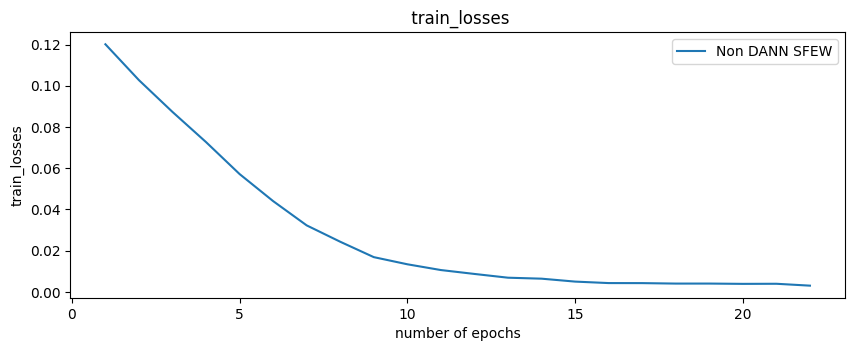

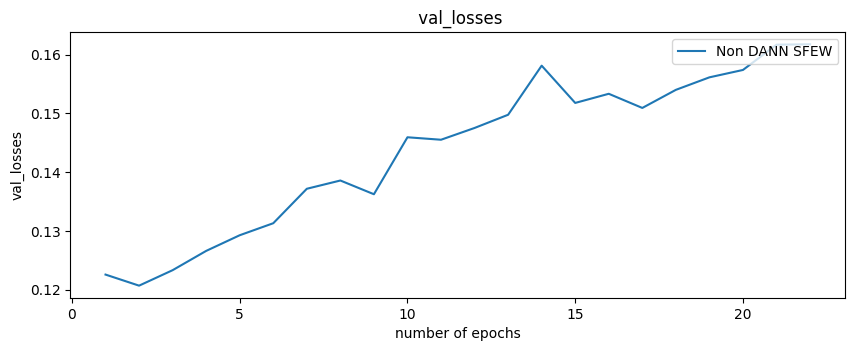

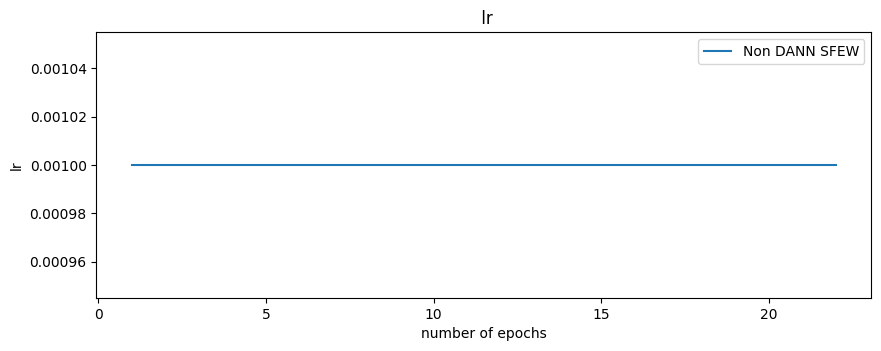

In [24]:
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='val_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='lr')

In [ ]:
model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [ ]:

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all
model_dann_ewc = loaded_model_non_dann # saves training time - check with all

# print(model_dann)

In [ ]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


In [ ]:

def execute_dann(model,device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = epoch
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [ ]:
lr_dann = runconfig.inital_lr
lr_dann = lr_dann / 5.0 # OVERRIDE
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
# n_epochs = 2 #OVERRIDE
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = sfew_train_loader,
                                                    source_val_loader = sfew_val_loader,
                                                    target_train_loader = expw_train_loader,
                                                    target_val_loader = expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain )

In [ ]:
dict_dann_losses

### DANN Plotting and Validation

In [ ]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='list_alpha')

### Saving DANN Model

In [ ]:
model_dann

In [ ]:

dann_model_name = "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
print(dataconfig_1)
MODEL_DIR = dataconfig_1.MODEL_DIR

try:
    DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
except:
    DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {DANN_SFEW_EXPW_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_SFEW_EXPW_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_SFEW_EXPW_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


## DANN EWC : Training, Validating, Saving

In [ ]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


In [ ]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [ ]:
model_dann_ewc

### EWC Code
Regularization Penalty

In [ ]:

from torch.autograd import Variable
from torch.autograd import Function

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [ ]:
ewc_object = EWC(deepcopy(model_dann_ewc),
                 data_loader=sfew_train_loader,
                 device=device,
                 class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate


In [ ]:

def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [ ]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/5.0 #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model_sfew_expw , dict_ewc_dann_losses_list_sfew_expw = execute_dann_ewc(model=model_dann,
                                                                                 device=device,
                                                                                 source_train_loader = sfew_train_loader,
                                                                                 source_val_loader = sfew_val_loader,
                                                                                 target_train_loader = expw_train_loader,
                                                                                 target_val_loader = expw_val_loader,
                                                                                 optimizer = optimizer_ewc_dann,
                                                                                 n_epochs = n_epochs,
                                                                                 class_loss_function = runconfig.criterion_class,
                                                                                 domain_loss_function = runconfig.criterion_domain,
                                                                                 EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                                                )

### DANN EWC Plotting and Validation

In [ ]:
dict_ewc_dann_losses_list_sfew_expw['test_loss_source'], dict_ewc_dann_losses_list_sfew_expw['test_loss_target']

In [ ]:
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='list_alpha')

### Saving DANN EWC Model

In [ ]:
ewc_dann_model_sfew_expw

In [ ]:

ewc_dann_model_name = "ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from data_config import DataConfig
dataconfig_2 = DataConfig()
print(dataconfig_2)
MODEL_DIR = dataconfig_2.MODEL_DIR

try:
    EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
except:
    EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    EWC_DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} already exists.')

try:
    torch.save(ewc_dann_model_sfew_expw.state_dict(), Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')
